In [13]:
import sys
sys.path.append('..')

from Helpers.Helpers import *
from Helpers.Environment import *

In [72]:
def Compute_path(x0,xf,factor,percent):
    xtarget = x0 + percent*(xf-x0)
    ts,te= newton(newtonf,newtondf,1e-8,1000,xtarget[0],xtarget[1])
    ts0,te0 = newton(newtonf,newtondf,1e-8,1000,x0[0],x0[1])
    mylambda = ts-ts0
    k = (te-te0)/mylambda
    Qk=np.zeros((8,8))
    
    Qk[0,0] = k*k
    Qk[0,6] = -k*k
    Qk[6,0] = -k*k
    Qk[6,6] = k*k
    Qk[0,3] = -k
    Qk[3,0] = -k
    Qk[0,7] = k
    Qk[7,0] = k
    Qk[1,6] = k
    Qk[6,1] = k
    Qk[6,7] = -k
    Qk[7,6] = -k
    Qk[3,3] = 1
    Qk[3,7] = -1
    Qk[7,3] = -1
    Qk[7,7] = 1
    return Qk*factor

In [3]:
def Feedback_Linearization_witPathConstraint(Duration = .6,w1 = 1e8,w2 = 1e8,w3 = 1e4,w4 = 1e4,wp = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30] ,Activate_Noise = False,Num_iter = 300,Showu=False, ShowJ = False, ShowEstimate = False,Delay = .06,AdditionalDynamics = {},taupath = .1,percent = .3):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Activate_Noise (boolean) : Gaussian variance associated to the white noises in the model

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement

    ShowEstimate (boolean) : Plot the estimated trajectory by the controller instead of the true trajectory

    Delay (float) : Internal Delay of the system in seconds

    AdditionalDynamics (dic) : Keywords describing supplementary environmental dynamics in the simulations 

        1) Velocity dependent ForceFields : 

            - FF (Boolean) : Describing whether there is a forcefield or not 
            - FFOnset (float) : Y threshold in cm after which the forcefield is activated 
            - Side (string: Left or Right ) : Describing on which side the lateral forcefield happen
    """

    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)
    obj1,obj2 = newton(newtonf,newtondf,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonf,newtondf,1e-8,1000,starting_point[0],starting_point[1])
    Qk = Compute_path(np.array(starting_point),np.array(targets),wp,percent)
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))

    #Incorporation of delay 

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    S = Q

    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = S
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B_basic.T@S@B_basic)@B_basic.T@S@A_basic
        array_L[Num_iter-2-k] = L
        S = Qk*np.exp(-k*dt/taupath)+A_basic.T@S@(A_basic-B_basic@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_x = np.zeros((Num_iter,Num_Var-2)) 
    array_z = np.zeros((Num_iter,Num_Var)) 
    array_u = np.zeros((Num_iter-1,2))
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x = np.zeros(Num_Var-2)
    x[0],x[1] = x0[0],x0[3]
    new_x = np.copy(x)
    array_x[0] = x

    #Incorporation of delay 

    #Perform the task
    J = 0
    acc = np.zeros(2)
    for k in range(Num_iter-1):
        #Compute the matrices of the FL technique in function of the current estimate state 
        
        F = EnvironmentDynamics(AdditionalDynamics,x,acc)

        C = np.array([-zhat[4]*(2*zhat[1]+zhat[4])*a2*np.sin(zhat[3]),zhat[1]*zhat[1]*a2*np.sin(zhat[3])])

        M = np.array([[a1+2*a2*cos(zhat[3]),a3+a2*cos(zhat[3])],[a3+a2*cos(zhat[3]),a3]])

        Cdot = np.array([-a2*zhat[5]*(2*zhat[1]+zhat[4])*sin(zhat[3])-a2*zhat[4]*(2*zhat[2]+zhat[5])*sin(zhat[3])
                         -a2*zhat[4]*zhat[4]*(2*zhat[1]+zhat[4])*cos(zhat[3]),2*zhat[1]*zhat[2]*a2*sin(zhat[3])+zhat[1]*zhat[1]*a2*cos(zhat[3])*zhat[4]])

        Mdot = np.array([[-2*a2*sin(zhat[3])*zhat[4],-a2*sin(zhat[3])*zhat[4]],[-a2*sin(zhat[3])*zhat[4],0]])
        
        Omega_motor,Omega_measure,motornoise,sensorynoise = NoiseAndCovMatrix(M,Num_Var,kdelay,Var = 1e-3*2)

        # Compute the command through the FL technique
        
        v = -L[k].reshape(np.flip(B_basic.shape))@zhat[:Num_Var]
        u = 1/Kfactor*M@(v)+1/Kfactor*Mdot@(np.array([zhat[2],zhat[5]]))+M@(np.array([zhat[2],zhat[5]]))+C+Bdyn@np.array([zhat[1],zhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([zhat[2],zhat[5]])
        array_u[k] = u
        if ShowJ : J+= u.T@R@u

        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        if Activate_Noise : 

            y[k]+=sensorynoise
        
        # Kalman Filter Gains 

        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_motor + (A - K@H)@sigma@A.T

        # Compute the Estimation of the system in the linear system
        
        zhat = A@zhat + B@v + K@(y[k]-H@zhat)
        
        # Simulate the nonlinear plant 
        
        C = np.array([-x[3]*(2*x[2]+x[3])*a2*np.sin(x[1]),x[2]*x[2]*a2*np.sin(x[1])])
        
        M = np.array([[a1+2*a2*cos(x[1]),a3+a2*cos(x[1])],[a3+a2*cos(x[1]),a3]])

        
        Cdot = np.array([-a2*acc[1]*(2*x[2]+x[3])*sin(x[1])-a2*x[3]*(2*acc[0]+acc[1])*sin(x[1])
                         -a2*x[3]*x[3]*(2*x[2]+x[3])*cos(x[1]),2*x[2]*acc[0]*a2*sin(x[1])+x[2]*x[2]*a2*cos(x[1])*x[3]])

        Mdot = np.array([[-2*a2*sin(x[1])*x[3],-a2*sin(x[1])*x[3]],[-a2*sin(x[1])*x[3],0]])
        
        new_x[0:2] += dt*x[2:4]
        new_x[2:4] += dt*(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))+F)
        new_x[4:6] += dt*Kfactor*(u-x[4:6])

        if Activate_Noise : 

            new_x[4:6]+=motornoise
        
        z = np.concatenate((np.array([new_x[0],new_x[2],acc[0],new_x[1],new_x[3],acc[1],z[6],z[7]]),z[:-Num_Var]))
        
        # Transform the new nonlinear state into the coordinates of the linear system
        C = np.array([-z[4]*(2*z[1]+z[4])*a2*np.sin(z[3]),z[1]*z[1]*a2*np.sin(z[3])])

        M = np.array([[a1+2*a2*cos(z[3]),a3+a2*cos(z[3])],[a3+a2*cos(z[3]),a3]])

        acc = np.linalg.solve(M,(new_x[4:6]-Bdyn@(new_x[2:4])-C))+F
        #Stock the true and estimated states

        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()
        array_x[k+1] = new_x[:Num_Var-2].flatten()
        
        x = np.copy(new_x)
        

    if ShowJ : 
        J+= z[:8].T@Q@z[:8]

    #Change of coordinates from angular to cartesian 
    

    data = array_z

    if ShowEstimate:
        data = array_zhat

    X,Y = ToCartesian(data,at3 = True)

    if ShowJ : return X,Y,J,array_x
    if Showu : return X,Y,array_u,array_x
    return X,Y



0.18448788745095412
-0.001955405490061691


(np.float64(-0.13872387882915457),
 np.float64(0.4298478203071495),
 np.float64(28.75013026252152),
 np.float64(56.247264482892))

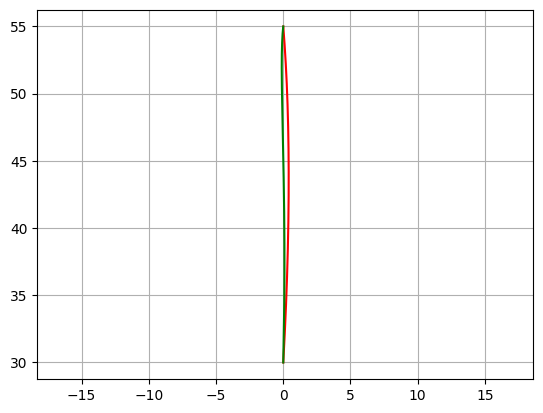

In [26]:
X,Y = Feedback_Linearization_witPathConstraint(wp = 0,taupath = 1e-2)
print(np.mean(X))
plt.plot(X,Y,color = "red")
X,Y = Feedback_Linearization_witPathConstraint(wp = 1,taupath = 1e-2)
print(np.mean(X))
plt.plot(X,Y,color = "green")
plt.grid()
plt.axis("equal")

(np.float64(-25.579724882251618),
 np.float64(36.90751712222544),
 np.float64(27.18845277651536),
 np.float64(49.23962140862666))

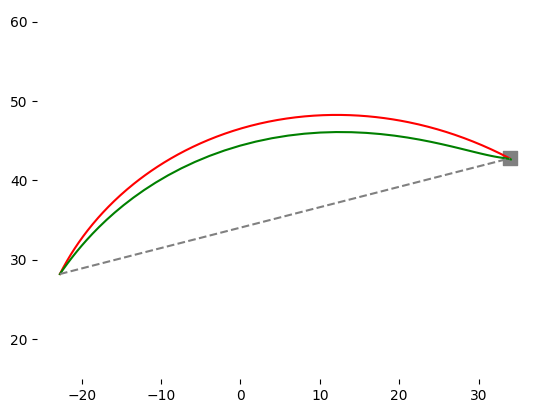

In [97]:
X0= [70,110]
XN=[20,60]

fig,ax = plt.subplots()
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)

plt.scatter(end[0],end[1],marker = "s",color="grey",s = 100)

X,Y = Feedback_Linearization_witPathConstraint(wp = 0,taupath = 1e-2,starting_point=start,targets=end)
plt.plot(X,Y,color = "red")
X,Y = Feedback_Linearization_witPathConstraint(wp = 30,taupath = .04,Num_iter=60,starting_point=start,targets=end,percent = .2)
plt.plot(X,Y,color = "green")
plt.plot(np.linspace(start[0],end[0],60),np.linspace(start[1],end[1],60),color = "grey",linestyle = "--")
delete_axis(ax)
plt.axis("equal")

(np.float64(-17.247017068832328),
 np.float64(31.772387336042367),
 np.float64(26.688414325028216),
 np.float64(50.93550191423345))

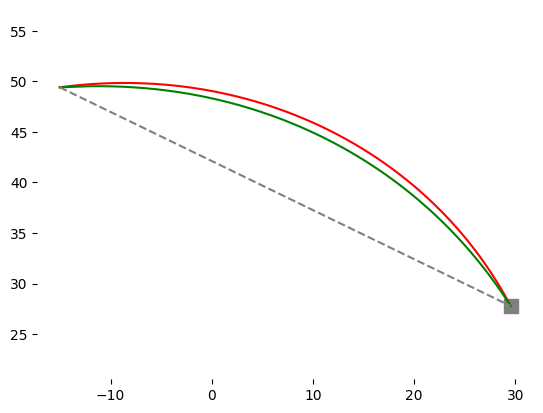

In [106]:
X0= [70,70]
XN=[-10,100]
fig,ax = plt.subplots()
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)

plt.scatter(end[0],end[1],marker = "s",color="grey",s = 100)

X,Y = Feedback_Linearization_witPathConstraint(wp = 0,taupath = 1e-2,starting_point=start,targets=end)
plt.plot(X,Y,color = "red")
X,Y = Feedback_Linearization_witPathConstraint(wp = 10,taupath = .04,starting_point=start,targets=end,percent =.2)
plt.plot(X,Y,color = "green")
plt.plot(np.linspace(start[0],end[0],60),np.linspace(start[1],end[1],60),color = "grey",linestyle = "--")
delete_axis(ax)
plt.axis("equal")

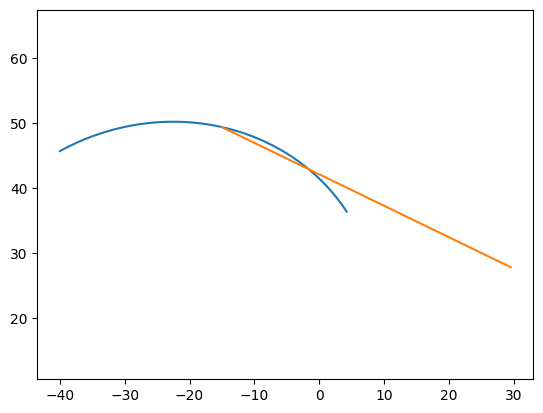

In [163]:
def test_path(x0,xf,percent):
    xtarget = x0 + percent*(xf-x0)
    ts,te= newton(newtonf,newtondf,1e-8,1000,xtarget[0],xtarget[1])
    ts0,te0 = newton(newtonf,newtondf,1e-8,1000,x0[0],x0[1])
    mylambda = ts-ts0
    k = (te-te0)/mylambda
    return ts0+np.linspace(-pi/4,pi/4,100),te0+np.linspace(-pi/4,pi/4,100)*k

start = np.array(ToCartesian(np.array([70,70])/180*pi))
end = np.array(ToCartesian(np.array([-10,100])/180*pi))
ts,te = test_path(start,end,.3)

X = np.cos(ts+te)*33+np.cos(ts)*30
Y = np.sin(ts+te)*33+np.sin(ts)*30
plt.plot(X,Y)
plt.axis("equal")
plt.plot(np.linspace(start[0],end[0],100),np.linspace(start[1],end[1],100))
